In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
# CHECK IF RUNNING INSIDE GOOGLE.COLAB

import sys
import os

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_walkthrough
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_walkthrough')
    # change working directory to project root
    os.chdir('/content/ts_walkthrough')
    # install requirements
    !pip install -r requirements.txt

# Практический обзор основных задач анализа временных рядов

В данном обзоре мы разберем основные задачи анализа временных рядов, такие как:

* [Статистический анализ](#statistical_analysis)
* [Прогнозирование](#forecasting)
* [Поиск аномалий](#anomaly_detection)
* [Классификация временных рядов](#time_series_classification)

Обзор содержит краткую теорию, достаточную для решения задач, и, практические задачи,
которые по большей части требуют написания кода. Такие задачи вы сможете найти по
комментарию `# <your_code_here>`. Большие же блоки практики вынесены в отдельные ноутбуки,
таких блоки вы сможете найти по слову "практика" в названии секции.

> ВНИМАНИЕ Если вы работаете в google.colab отдельные ноутбуки нужно запускать как новые 
> инстансы:
1. Выберите ноутбук в корне репозитория (напрмер, `arima.ipynb`)
2. Скачайте его (download в выпадающем списке)
3. Откройте как новый runtime (File -> Upload notebook)

Список рекомендуемой литературы вы сможете найти в конце обзора.

Удачи!


# <a id='statistical_analysis'>Статистический анализ</a>

Прежде чем строить какие-либо модели, бывает крайне полезно посмотреть на ваши временные
ряды, покрутить их "туда-сюда", чтобы понять их основные характеристики. Это поможет вам
лучше понять, какой подход использовать или свести задачу к гораздо более простой. Иногда,
вдумчивый статистический подход сам по себе может являться моделью прогнозирования или
поиска аномалий, способную опередить ML и DL подходы.

Данная секция состоит из следующих частей:

1. [Знакомимся с основными понятиями](#basic_concepts)
2. [Преобразования временных рядов](#time_series_transformations)
3. [Как преобразовать ряд к стационарному](#making_series_stationary)
4. [Разложения временных рядов, STL разложение](#time_series_decomposition)

## <a id='basic_concepts'>Знакомимся с основными понятиями</a>


### *Что такое временной ряд?*  


Временным рядов является любая упорядоченная последовательность чисел (или набора чисел),
взятая с равными промежутками времени. На практике, мы всегда имеем дело с пропусками в
данных, поэтому какими-то пропусками в данных приходится пренебрегать. Тем не менее, если
вы имеете дело с числами, взятыми с совсем случайными интервалами, вы уже переходите в
область стохастических процессов и теория, приведенная в данном обзоре, будет плохо к ним
применима.

Итак, временной ряд формально:

$$
ts = \{(t_i, v_i): i \in {0...N}, v_i \in R^N, t_{i+1} - t_i = C \: \forall i\}
$$

В питоне наиболее подходящей структурой данных для работы с временным рядов является 
`pandas.Series` (для хранения многомерных временных рядов используйте `DataFrame`)

In [117]:
import pandas as pd
from random import randint

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1h', periods=100)
)

`data` любой итерируемый обьект
`index` также любой итерируемый обьект, равный по длине `data`. Для задач временных рядов 
нам необходимо, чтобы он состоял из обьектов datetime, создать которые можно либо
средствами стандартной библиотеки datetime либо средствами pandas. Обратите внимание, что,
чтобы задавать временные интервалы, нужно использовать стандарт ISO8601 (подробнее [здесь](#ref_1))

Изучите самостоятельно многообразие доступных методов класса pd.Series. 

В нашем туториале мы будем использовать разные временные ряды в качестве примеров. Для
удобной работы с ними, вы можете использовать класс `Dataset` из модуля `dataset` в корне
вашего репозитория.

In [118]:
from dataset import Dataset

ds = Dataset('./data/dataset')

# посмотреть временные ряды
print(ds)

# достать конкретный временной ряд
ds['international-airline-passengers.csv']

# проитерироваться по всем рядам
for key, s in ds:
    pass

day_2690.csv
day_2135.csv
day_1164.csv
day_3015.csv
day_1158.csv
day_1776.csv
day_1762.csv
day_309.csv
hour_376.csv
day_321.csv
day_335.csv
day_2531.csv
hour_1804.csv
day_1574.csv
day_1206.csv
day_2069.csv
day_3376.csv
day_687.csv
day_2915.csv
day_2901.csv
day_3148.csv
day_2256.csv
day_1039.csv
day_446.csv
day_1777.csv
day_2281.csv
day_1159.csv
day_2450.csv
day_2336.csv
day_2493.csv
hour_3380.csv
day_724.csv
day_718.csv
day_2108.csv
hour_2263.csv
day_2685.csv
day_2875.csv
stl_example.csv
day_915.csv
day_929.csv
day_1403.csv
day_2888.csv
hour_3625.csv
day_1832.csv
day_1173.csv
day_2308.csv
day_1601.csv
day_1167.csv
day_2334.csv
day_493.csv
day_2283.csv
day_3610.csv
day_1007.csv
day_1761.csv
day_478.csv
hour_3553.csv
hour_3426.csv
hour_3618.csv
hour_3387.csv
hour_3594.csv
hour_2098.csv
hour_3621.csv
hour_3192.csv
hour_3019.csv
daily-min-temperatures.csv
international-airline-passengers-anomaly.csv
seasonal_stl.csv
dow_jones_3.csv
dow_jones_2.csv
international-airline-passengers.csv
dow_j

### *Графики временных рядов*

Любой анализ временных рядов предполагает визуализацию данных, для этого нам необходимо
уметь рисовать графики временных рядов. Самый простой способ - использовать встроенный
метод `plot` обьекта series.

<Axes: >

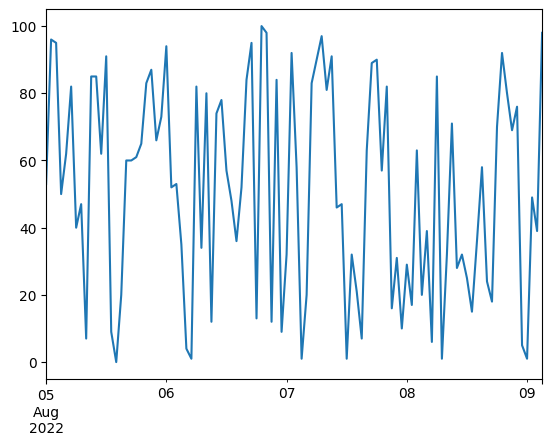

In [119]:
ts.plot()

Тем не менее, есть более интерактивные варианты для отрисовки графиков, такие как
библиотеки bokeh и plotly, например. Можете использовать функцию `plot_ts` из корня вашего
репозитория, как пример.

Обратите внимение, насколько информативнымии становятся графики!

In [120]:
from plotting import plot_ts

plot_ts(ts)

Loading BokehJS ...

### *Гранулярность временного ряда или частота*

Гранулярностью временного ряда (или частотой) называется временной интервал между двумя
соседними точками временного ряда. Она показывает, насколько "плотно" распределены точки в
истории.

In [121]:
print((ts.index[1] - ts.index[0]))

0 days 01:00:00


### *Лаг(-и) временного ряда*

Работая с временными рядами, вы будете часто слышать термин `лаг`. Данный термин может
быть употребим либо по отношению ко всему временному ряду, либо по отношению к конкретной
точке $(t_i, v_i)$.

Когда термин лаг используется в контексте точки, `k-ый лаг` для
точки $(t_i, v_i)$ означает точку $(t_{i-k}, v_{i-k})$ вглубь истории.

Будучи применен ко всему ряду `k-ый лаг` означает ряд, сдвинутый `k` раз вправо (назад во
времени), таким образом, что каждая точка $(t_i, v_i)$ становится точкой $(t_i, v_{i-k})$

In [122]:
plot_ts(ts, ts.shift(10))

Loading BokehJS ...

### *Горизонт прогнозирования*

Горизонтом прогнозирования h называют количество точек в будущее, на которое делается
прогноз, обычно пишут $Y_{t+h}$.

### *Автокорреляция*

Практически во всех задачах анализа временных рядов важно знать, содержит ли ваш ряд 
какую-либо временную зависимость (т.е. коррелируют ли точки из прошлого с точками из будущего),
потому что прогнозирование временных рядов без доп признаков основано исключительно
на прошлых значениях временного ряда. Одним из лучших способов найти такую зависимость 
является расчет автокорреляции, т.е. корреляции между изначальным временным рядом и рядом,
сдвинутым назад во времени.

Говоря математически, автокорреляция ряда $Y_t$ при $k$-ом лаге определяется как хорошо
известная корреляция Пирсона, взятая от двух рядов, изначального и взятого с лагом $k$.

$$\rho_{Y_t, Y_{t-k}} = \frac{\operatorname{cov}({Y_{t-k}},Y_t)}{\sigma_{Y_{t-k}} \sigma_{Y_t}} = \frac{E[(Y_t-\mu_{Y_t})(Y_{t-k}-\mu_{Y_{t-k}})]}{\sigma_{Y_{t-k}} \sigma_{Y_t}}$$

Большие значения автокорреляции на каком либо лаге $k$ сигнализируют, что вы, возможно,
имеете сильную периодческую зависимость с периодом $1/k$.

In [123]:
# в питоне, вы можете легко посчитать корреляцию при помощи метода `corr` обьекта series

ts.corr(ts.shift(10))

0.1017407081290796

### *Частичная автокорреляция*

Когда мы расчитываем автокорреляцию ряда $Y_t$ при лаге $K$, мы подразумеваем, что все
промежуточные лаги тоже могут вносить определенный вклад в разброс значений $Y_t$. 
Но, что если мы хотим узнать, как зависит ряд в текущий момент времени от лага $K$,
если убрать влияние всех промежуточных лагов? Тогда, мы должны сначала построить линейную
регрессию ряда $Y_t$ на все промежуточные значения $Y_{t-1}$, $Y_{t-2}$, ..., $Y_{t-K+1}$.
После чего вычесть прогноз регрессии из исходного ряда. Тогда, автокорреляция полученного
ряда при лаге $K$ будет являться частичной автокорреляция исходного ряда при этом же лаге.

Формально, частичная корреляция определяется следующим образом:

$$
pacf(y_t, y_{t-k}) =
\begin{cases}
    corr(y_{t-k}, y_t) , k=1,\\
    corr(y_{t-k} - y_{t-k}^{'}, y_t - y_t^{'}),k>1,
\end{cases},
$$

где 
$y_{t}^{'}$ - линейная регрессия на $y_{t-1}, y_{t-2}, ..., y_{t-k+1}$,  
т.е. $y_{t}^{'} = \alpha_1 y_{t-1}^{'} + \alpha_2 y_{t-2}^{'} + ... + \alpha_{k-1} y_{t-k+1}^{'}$
и аналогично для $y_{t-k}^{'}$

In [124]:
# в питоне частичную автокорреляция можно посчитать при помощи функции pacf из statsmodels
from statsmodels.tsa.stattools import pacf

pacf(ts, 30)

array([ 1.        ,  0.20149451,  0.03818829, -0.04662245, -0.14493351,
       -0.10583524, -0.02151503, -0.09949454, -0.00810343,  0.14453795,
        0.02715191,  0.02351587,  0.02286518,  0.12199964,  0.09173396,
       -0.02908399,  0.05918361, -0.065424  ,  0.03892983,  0.10448098,
       -0.02072343, -0.04073974, -0.00290958,  0.10696753,  0.01174759,
        0.19528097, -0.17635263, -0.19478018, -0.18930301, -0.01805507,
       -0.17715148])

### *Графики acf и pacf*

Зависимость значения автокорреляции (частичной автокорреляции) от порядка лага называется
графиком автокорреляции или графиком частичной автокорреляции.

Графики автокорреляции используются для того, чтобы посмотреть, есть ли у временного ряда
какая либо временная зависимость. Например, для ряда белого шума, график автокорреляции
будет выглядеть как шум, без значимых пиков, а для ряда $sin(t)$ график автокорреляции
будет выглядеть как $sin(t)$

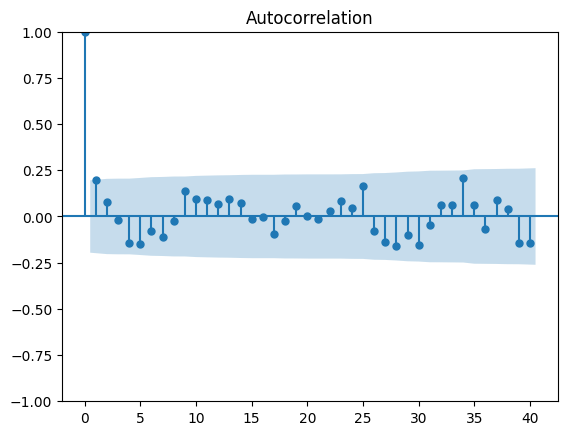

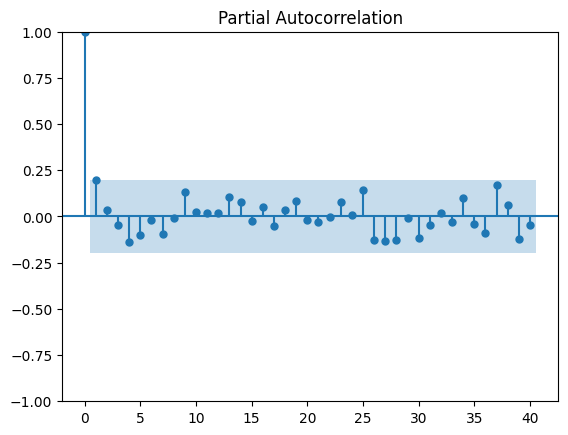

In [125]:
# в питоне готовые функции для отрисовки можно найти в библиотеке statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts, lags=40);
plot_pacf(ts, lags=40);

На графиках выше можно заметить, что какая либо структура в данных отсуствуют, т.к. мы
наблюдаем 100% корреляцию при нулевом лаге (когда ряд совпадает сам с собой) и случайные
корреляции на всех остальных лагах. Т.к. мы изначально генерировали случайный ряд, такой
результат очевиден.

### *Компоненты временного ряда*

Каждый временной ряд может содержать одну (или несколько) следующих компонент
временного ряда:

* гетероскедастичность
* тренд
* сезонность
* цикличность
* шум

#### Гетероскедастичность

Непостояноство дисперсии временного ряда называется гетероскедастичностью, на примере ниже
можно видеть, как ряд имеет возрастающую дисперсию.

In [126]:
ts = ds['alcohol_sales.csv']

# первый график показывает изначальный ряд, второй график - скользящее std
plot_ts(ts, ts.rolling(12).std())

Loading BokehJS ...

#### Тренд

У понятия тренда нет четкого формального определения, в целом его можно охарактеризовать
как долговременную тенденцию к изменению временного ряда. Часто, когда говорят о тренде,
имеют ввиду линейный тренд, но он вообще говоря может быть полиномом произвольной степени.

Обнаружить тренд легко можно на самом графике временного ряда либо на графике 
автокорреляции, ряды с трендом на нем выглядят как убывающая или возрастающая (зачастую
монотонно) зависимость.

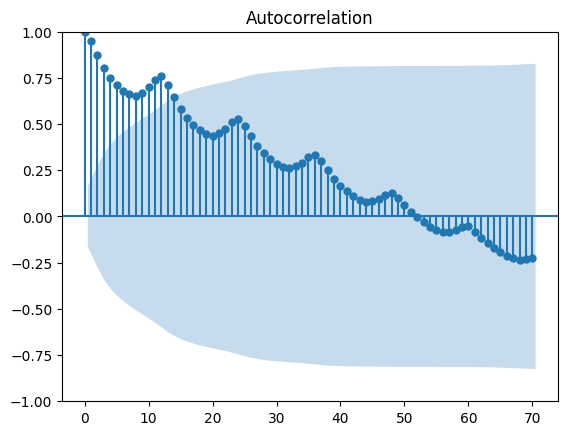

In [127]:
ts = ds['international-airline-passengers.csv']

# видим линейно автокорреляцию с ростом порядка лага, что свидетельствует о наличии тренда
plot_acf(ts, lags=70);

#### Сезонность и период сезонности временного ряда

Если $y_t = y_{t-s} + e(t) \forall t, \text{где e(t) - шум}$, то говорят, что временной
ряд имеет сезонность с периодом s. (*примечание: тут мы подразумеваем, что мы исключили
все остальные компоненты, включаю другие сезонности).
Определить сезонность можно либо по графику самого временного ряда, либо по графику
автокорреляции.
Если на графике автокорреляции вы наблюдаете периодические всплески автокорреляции через
равные промежутки времени, то ряд скорее всего имеет сезонность.

Loading BokehJS ...

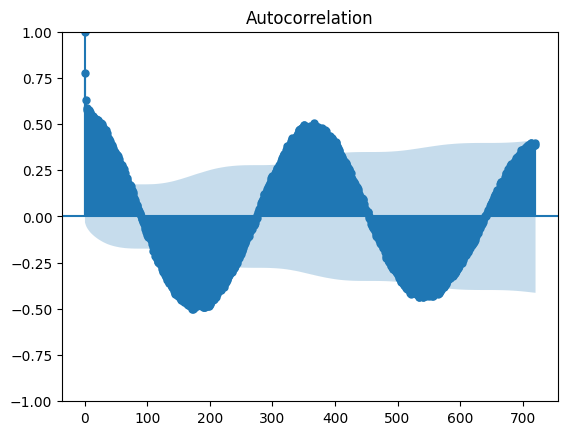

In [128]:
ts = ds['daily-min-temperatures.csv']

plot_ts(ts)
plot_acf(ts, lags=720);

#### Цикличность

Если временной ряд имеет повторяющийся паттерн, но, в отличии от сезонности, период его не
является постоянным, то мы имеем дело с цикличностью.

#### Шум

Если мы исключим из временного ряда все вышеперечисленные компоненты, то все, что у нас
останется, является случайной частью временного ряда - неким шумом из некоего распределения.

В эту же компоненту входят выбросы и различные аномалии.

График автокорреляций для шума не должен содержать каких-либо значимых автокорреляций.

Loading BokehJS ...

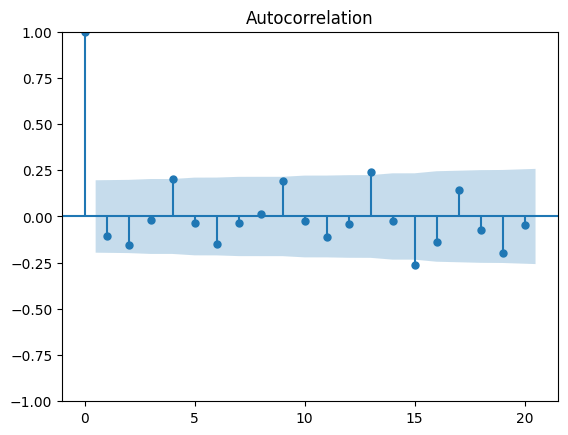

In [129]:
from random import randint

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1h', periods=100)
)

plot_ts(ts)
plot_acf(ts);

### Понятие стационарности временного ряда

Одним из ключевых понятий в классическом, эконометрическом анализе временных рядов
является понятие стационарности. Познакомимся с ним подробнее.

#### Определение

Формально временной ряд $y_1, y_2, ..., y_t$ называется стационарным, если $\forall s$
распределение $y_t, ..., y_{t+s}$ не зависит от времени, а именно:

* $VAR(y_t) = const$
* $E(y_t) = const$
* $COV(y_t, y_{t-k}) = const \forall k$

#### Интуитивное определение

Говоря неформальным языком, стационарным временным рядом является такой временной ряд,
который мы избавили от любой формы "непостоянства". 

По сути, все компоненты временного ряда, за исключением шума, представляют собой ту или 
иную форму "непостоянства" во временном ряде. Гетероскедастичность показывает
непостоянство дисперсии, тренд и сезонность - изменчивость матожидания. Как мы узнаем
немного позже, умение "убирать" из временного ряда все возможные формы непостоянства -
ключевой навык для построения классических моделей прогнозирования. Сделать это можно при
помощи различных преобразований временного ряда.

#### Как убедиться, что ряд стационарен

Есть два основных способа убедиться в стационарности временного ряда.

1. Используя визуальный анализ исходного графика и графика автокорреляции.
2. Используя статистические тесты.

**Визуальный анализ**

При визуальном анализе мы обращаем внимание на то, есть ли у временного ряда непостоянные
компоненты - гетероскедастичность, тренд, сезонность. Обратите внимание, что цикличность
не является компонентной непостоянства, так как период цикличности является случайной
величиной и матожидание, дисперсия и ковариация данного процесса будут константными.

Давайте посмотрим на пример ниже. В изначальном ряде на обоих графиках мы наблюдаем и
тренд и сезонность и гетероскедастичность. Данный ряд явно не является стационарным.

Loading BokehJS ...

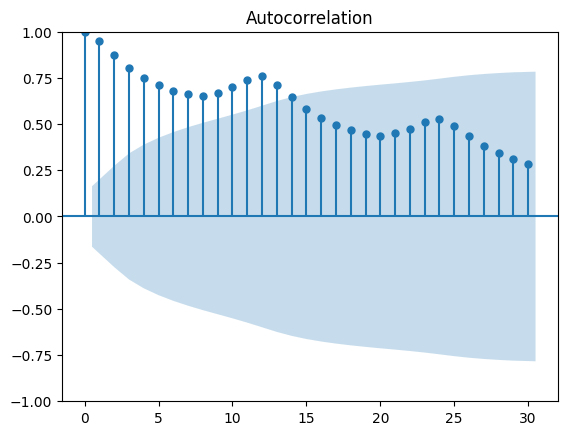

In [130]:
ts = ds['international-airline-passengers.csv']

plot_ts(ts)
plot_acf(ts, lags=30);

Теперь рассмотрим график белого шума.

Loading BokehJS ...

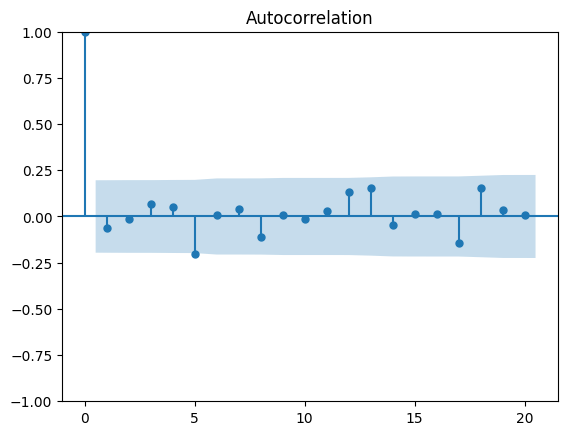

In [131]:
ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1h', periods=100)
)

plot_ts(ts)
plot_acf(ts);

Здесь мы не видим никакого тренда, сезонности или гетероскедастичности. А график
автокорреляции показывает резкий спад корреляции в незначимый диапазон сразу после 0-го
лага. Этот ряд явно стационарен.

**Статистические тесты**

Вторым способом является проверка ряда на стационарность при помощи какого-нибудь
статистического теста. Два самых популярных теста для проверки ряда на стационарность -
тест [KPSS](#ref_3) и [Dicky-Fuller](#ref_4). Мы будем использовать второй. В рамках 
данного обзора мы не будем вдаваться в теорию, стоящую за данными тестами, и будем 
использовать их как "black box".

Нулевой гипотезой теста является предположение о том, что ряд не стационарен. Если значение
p-value меньше определенного порога (обычно 5%), мы можем смело отвергнуть нулевую 
гипотезу и считать ряд стационарным.

На примере ниже мы видим, что значение p-value сильно меньше 5 процентов, соотвественно мы
смело отвергаем нулевую гипотезу и говорим, что ряд с большой долей уверенности можно
назвать стационарным.

In [132]:
from statsmodels.tsa.stattools import adfuller

ts = pd.Series(
    data=[randint(0, 100) for _ in range(100)],
    index=pd.date_range(start='2022-08-05', freq='1H', periods=100)
)

p_value = adfuller(ts)[1]
p_value

/var/folders/xk/304zh5617yn50x0ys84shn5m0000gn/T/ipykernel_61685/3059983339.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start='2022-08-05', freq='1H', periods=100)


9.156375532556285e-20

На не стационарном ряде мы видим, наоборот, большие значение p-value, соотвественно, не
можем отвергнуть нулевую гипотезу и говорим, что ряд не стационарен.

In [133]:
ts = ds['international-airline-passengers.csv']

p_value = adfuller(ts)[1]
p_value

0.9915115096288659

Тем не менее, автоматического способа, который со 100% гарантией давал бы вам вердикт о
стационарности не существует, к тому же условие стационарности, как и любое другое
статистическое понятие, может определяться лишь с некоей вероятностью. Поэтому этот
требует некоего опыта.

>Посмотрите картинку ниже, как вы думаете, какие из данных рядов можно назвать
стационарными?

<img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/ts_types.png" alt="drawing" width="400">

Стационарными рядами можно назвать ряды b, g.

## <a id='time_series_transformations'>Преобразования временных рядов</a>

Преобразования временных рядов позволяют вам избавиться от всех нестационарных компонент.
Рассмотрим основные преобразования.

### *Временные преобразования временного ряда*

Представьте, что вам дали задачу спрогнозировать среднегодовую минимальную температуру в 
определенном районе, при этом у вас имеются данные минимальной температуры за каждый день
в течении нескольких лет. Для того чтобы спрогнозировать температуру на следующий год, вам
необходимо сделать прогноз на 365 дней вперед и потом усреднить значение. Тем не менее,
такая задача может быть весьма сложной. Однако, на самом деле, вам не нужно знать
температуру на каждый день - вместо этого вы можете взять среднее значение за каждый год и
спрогнозировать уже этот, новый, годичный ряд. Таким образом перейти от дневной
гранулярности к годичной. Такие преобразования называется временными.

>Попробуйте расчитать среднее значение температуры на следующий год для ряда
>`daily-min-temperatures.csv`, используя временное преобразование. Для этого рассчитайте
>среднее за каждый год и перейдите к годичному ряду, после чего посмотрите на ряд и оцените
>среднее значение температуры на следующий год.

In [134]:
ts = ds['daily-min-temperatures.csv']
# your code here

### *Логарифмирование временного ряда*

Самым простым способом убрать непостоянство дисперсии во временном ряде является операция
логарифмирования.

$$y_t^{log} = log{y_t}$$

>Попробуйте применить операцию логарифмирования к ряду `alcohol_sales.csv` и посмотрите как
>изменится ряд. Получилось ли убрать непостоянство дисперсии?

In [135]:
ts = ds['alcohol_sales.csv']
# your code here


Развитием идеи логарифмирования ряда является преобразование Бокса-Кокса, которое
предполагает трансформация ряда при помощи произвольной степенной функции. Данное
преобразование мы оставим за рамками данного обзора, можете ознакомиться с ним
самостоятельно [здесь](#ref_2).

### *Дифференцирование временного ряда (или взятие разностей)*

Убрать тренд или сезонность проще всего при помощи дифференцирования временного ряда, т.е. перейдя от асболютных величин к их разностям, кроме того, работая с временными рядами, очень часто хочется посмотреть не на сам ряд, а на его изменение. Чтобы можно было сказать, насколько ряд меняется с каждой новой точкой, или,
скажем, насколько у дневного ряда различаются значения вчера и сегодня.

Пусть имеется ряд $y_t$, тогда, дифференцированным с лагом $k$ будет называться ряд вида
$y_t^{'} = y_t - y_{t-k}$

Для операции дифференцирования также часто вводят понятие порядка $d$. Дифференцированным
рядом порядка $d$ с лагом $k$ называется ряд, который $d$ раз продифференцирован с лагом
$k$.

В питоне операцию дифференцирования легко осуществить при помощи метода `diff` класса
TimeSeries.

In [136]:
ts = ds['international-airline-passengers.csv']

# взятие первой разности с лагом 1
ts.diff()

# взятие первой разности с лагом 12
ts.diff(12)

# взятие второй разности с лагом 1
ts.diff().diff()

# можно также комбинировать порядок и лаг
ts.diff().diff(12)

# посмотрим, как все выглядит на графике
plot_ts(ts, ts.diff(), ts.diff(12))

Loading BokehJS ...

In [137]:
import numpy as np

plot_ts(ts, np.log(ts))

Loading BokehJS ...

>Попробуйте избавить ряд `daily-min-temperatures` от сезонности при помощи операции дифференцирования

In [138]:
ts = ds['daily-min-temperatures.csv']
# your code here


## <a id='making_series_stationary'>Приведение ряда к стационарному</a>

>Используя вышеперечисленные преобразования, приведите ряд alcohol_sales.csv к
>стационарному виду. Критерием стационарности должны служить соотвествующий график
>автокорреляции и низкое значение p-value статистики Дики-Фуллера

In [139]:
ts = ds['alcohol_sales.csv']

# <your_code_here>

## <a id='time_series_decomposition'>STL разложение</a>

Зачастую, временной ряд можно разложить на три компоненты: тренд, сезонность и остаток. 
В таком случае, мы можем сильно упростить себе задачу прогнозирования такого ряда - ведь
вместо того, чтобы прогнозировать весь ряд целиком, мы можем спрогнозировать отдельно
тренд, сезонность и остаток, которые почти наверняка будут иметь более простую структуру,
нежели изначальный ряд, после чего сложить полученные прогнозы. Именно на этом основан
метод STL(seasonal-trend-loess) разложения.

In [145]:
ts = ds['stl_example.csv']

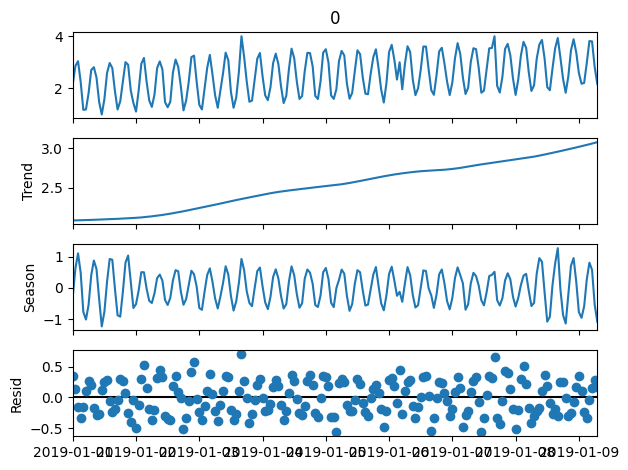

In [146]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, seasonal=5)
res = stl.fit()
fig = res.plot()

#### **Разберем наивную реализацию алгоритма STL.**

`Примечание` Оригинальная [статья](#ref_5), предложившая данный метод, подразумевает
реализацию loess регрессии,но мы, для простоты, будет использовать вместо нее медианный
фильтр и предположение о линейности тренда.

Пусть имеется временной ряд $Y_t$, представимый в виде суммы тренда $T_t$, сезонности $S_t$,
остатка $R_t$, т.е. $Y_t = T_t + S_t + R_t$ (с поправкой на возможную гетероскедастичность),
тогда:

1. Первым делом, если нужно уберем гетероскедастичность

$Y_t = log(Y_t)$

2. Далее найдем тренд, построив линейную регрессию Y(X).

$T_t = \alpha X_t + \beta$
$\alpha,\beta: MSE(T, Y) -> min$

3. Вычтем тренд из ряда Y_t

$Y_t^{detrended} = Y_t - T_t$

4. Чтобы получить сезонность и остаток, применим дифференцирование с лагом, равным периоду
   сезонности. Тогда, полученный в результате дифференцирования ряд будет остатком $R_t$, а
   сезонность может быть получена, как:

$S_t = Y_t^{detrended} - R_t$

6. Признаком хорошего разложения будет служить стационарность остатков.

Теперь, разложив ряд на компоненты, можем сделать прогноз каждой компоненты, после чего
сложить получившиеся прогнозы, чтобы получить прогноз исходного ряда.

1. Прогноз тренда получается интерполяцией найденной зависимости

$T_{t+h} = \alpha X_{t+h} + \beta$

2. Прогноз сезонности получается рекурсивно

$S_{t+h} = S_{t+h-s}$

3. Остатки, как мы узнаем с вами далее, нужно по-хорошему прогнозировать моделью ARMA. Но
   в нашем случае положим остатки нулю, таким образом, не учтя их в прогнозе.

$R_{t+h} = 0$

4. Итоговый прогноз получим как сумму всех компонент

$Y_{t+h} = T_{t+h} + S_{t+h} + R_{t+h}$

Сделайте прогноз ряда co2.csv на 36 лагов вперед при помощи stl разложения.

In [170]:
ts = ds['co2.csv']

# уберите гетероскедастичность логарифмированием

# <your_code_here>

In [171]:
# найдите тренд, построив линейную регрессию на шкалу абсцисс

# <your_code_here>

In [122]:
# вычтите полученный тренд из исходного ряда

# <your_code_here>

In [123]:
# получите остаток, применив сезонное дифференцирования
# период сезонности можно найти либо по изначальному графику временного ряда, либо по
# графику автокорреляции

# <your_code_here>

In [124]:
# получите сезонность, вычтя из ts_detrended полученный выше остаток

# <your_code_here>

In [125]:
# сделайте прогноз тренда при помощи интерполяции тренда на следующие 36 точек

# <your_code_here>

In [126]:
# сделайте прогноз сезонности рекурсивным способом
# (можно взять последний период сезонности и продублировать его 6 раз)

# <your_code_here>

In [172]:
# нарисуйте полученный прогноз вместе с исходным рядом 
# (не забудьте взять экспоненту от обоих компонент, чтобы перейти к изначальному, не логарифмированному масштабу)

# <your_code_here>

# <a id='forecasting'>Прогнозирование</a>

В данной части мы познакомимся с задачей прогнозирования временных рядов. Формально
говоря, задача прогнозирования сводится к тому, чтобы найти следующую функцию $f(T)$:

$$
y_{T+d} \approx f_T(Y_T, ..., y_1, d) \equiv \hat{y}_{T+d|T}
$$

То есть по имеющейся истории максимально правдоподобно описать будущие значения на
заданный горизонт прогнозирования.

Когда в каждый момент времени мы прогнозируем только на одну точку вперед, т.е. горизонт
прогнозирования $d=1$, такой прогноз называют one step ahead прогноз. В противном случае,
называют multi step ahead прогноз.

Прогноз, сделанный ретроспективно на исторических данных на одну точку вперед,
называется in sample прогноз. Прогноз, сделанный вне обучающей выборки,
называется out of sample прогноз.

Данная секция состоит из следующих частей:

1. [Тривиальные модели прогнозирования](#trivial_models)
2. [Семейство моделей ARIMA](#arima)
3. [Supervised подход к прогнозированию](#supervised_approach)
4. [DL подход к прогнозирования](#dl_approach)

## <a id='trivial_models'>Тривиальные модели прогнозирования</a>

Прежде чем переходить к каким-то сложным моделям, рассмотрим наиболее простые.

### Наивная модель

Наивная модель предполагает прогнозирование всех следующих точек временного ряда, равной
текущей точке, т.е.

$$\hat{y}_{T+d|T} = Y_T$$

Несмотря на невероятную простоту данной модели, она бывает крайне полезной в случаях,
когда вам нужно сделать прогноз рядов, хорошо описывающихся моделью случайного
блуждания.

Кроме того, очень часто в качестве метрик прогнозирования, используют метрику, основанную
на сравнении вашего метода с наивным. Это нужно для того, чтобы удостовериться, что
построение каких-либо сложных моделей вообще имеет смысл.

Давайте попробуем сделать наивный in-sample прогноз.

In [47]:
ts = ds['dow_jones_0.csv']

# в данном случае мы можем легко сделать наивный прогноз при помощи shift

in_sample_naive_forecast = ts.shift()

plot_ts(ts, in_sample_naive_forecast)

Loading BokehJS ...

> попробуйте сделать out of sample наивный прогноз для временного ряда dow_jones_0.csv на
> 300 точек вперед

In [129]:
# <your_code_here>
# так как мы прогнозируем по последней точке, прогнозом на весь горизонт прогнозирования
# будет просто являться константа, равная этой точке


### Модель сдвига

Другой простой моделью является модель сдвига. В рамках данной модели мы выбираем две
точки временного ряда (часто первая и последняя) и строим по этим двум точкам прямую.
Интерполяция данной прямой на горизонт прогнозирования и будет являться прогнозом модели
сдвига.

Модель свдига хорошо подходит для приблизительного прогнозирования тренда случайных
блужданий, котировок акций и т.п.

### Модель среднего (медианы)

Еще одной простой моделью является модель среднего. В таком случае мы прогнозируем
следующие значения ряда как среднее N последних лагов.

Пример in-sample прогноза, полученного таким способом

In [48]:
# mean
plot_ts(ts, ts.rolling(30, center=False).mean())

# median
plot_ts(ts, ts.rolling(30, center=False).median())

Loading BokehJS ...

Loading BokehJS ...

*Примечание*
В качестве домашнего задания предлагается ознакомится с моделями экспоненциального
сглаживан ия, основной идеей которых является идея присваивать разные веса разным лагам, в
зависимости от того, насколько далеко в истории находится лаги.

## <a id='arima'>Семейство моделей ARIMA</a>

Одними из самых популярных моделей прогнозирования являются модели семейства ARIMA. До сих
пор они показывают прекрасное качество прогнозирования, когда речь идет о ручном
построении модели, а не об автоматическом прогнозировании. Особенно хорошо данныые модели
показывают себя на рядах с короткой историей, т.е. когда нет большого количества
исторических данных. 

В этой секции мы рассмотрим теоретические основания моделей ARIMA, и научимся строить
модели ARIMA разными способами - вручную и автоматически.

Для начала мы разберем несколько важных типов временных рядов, после чего узнаем, зачем
они нам нужны и перейдем к построению моделей ARIMA.

### MA процесс (процесс скользящего среднего)

Начать разбор ARIMA имеет смысл с рассмотрения процесса MA (moving average). Как мы с вами
уже знаем, каждая точка временного ряда содержит случайную(шумовую) компоненту $e_t
\approx N(0, \sigma^2)$.

Теперь представьте, что каждая точка временного ряда получается как линейная комбинация 
предыдущих шумов $e_{t-1}$, ..., $e_{t-p}$, шума в текущий момент времени $e_{t}$, и
некоей константы С. 

$$
y_t = e_{t} + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_p e_{t-p} + С
$$

Тогда, временной ряд, полученный таким способ, будет называться процессом скользящего
среднего, а параметр p будет называется порядком MA процесса.

Свойством процесса скользящего среднего будет являться то, что данный процесс всегда будет
стационарный (можете посчитать для такого процесса матожидание, дисперсию и ковариацию).

### AR процесс (процесс авторегрессии)

Теперь представим, что каждая точка временного ряда получается как шум в текущий момент
времени $e_t$, плюс константа С, плюс линейная комбинация предыдущих значений временного
ряда. Т.е. строится регрессия на сами наблюдаемые значения временного ряда, а не
только на их шумовые компоненты.

$$
y_t = e_{t} + \phi_1 p_{t-1} + \phi_2 p_{t-2} + ... + \phi_p p_{t-p} + С
$$

Тогда, временной ряд, полученный таким способом, будет называться авторегрессионным, а
параметр p - порядком авторегрессии.

Данный процесс не всегда является стационарным, для этого необходимо, чтобы все
коэффициенты лежали на так называемом единичном круге, т.е., для, скажем, процесса 
$AR(1) = e_{t} + \phi_1 p_{t-1} + С$, условие стационарности следующее:

$$
-1 < \phi_1 < 1
$$
>

### ARMA процесс

Если мы теперь объединим процессы AR и MA, то получим ряд, одновременно зависящий и от
предыдущих шумовых компонент и от предыдущих значений временного ряда. 

$$
y_t = e_{t} + \phi_1 p_{t-1} + \phi_2 p_{t-2} + ... + \phi_p p_{t-p} + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_p e_{t-p} + С 
$$

Этот процесс будет называться процессом ARMA(p, q), а параметры p, q - будут параметрами
ARMA процесса.

### Теорема Вольда

Вы могли задаться вопросом, зачем мы рассматривали все вышеперечисленные процессы? Ответом
на данный вопрос является теорема [Вольда](#ref_6). Теорема Вольда звучит следующим
образом :

> Любой стационарный ряд может быть представлен в виде процесса ARMA(p, q),
> при том, чем больше порядки p и q, тем с большей точностью мы представляем ряд.
> $$ y(t) \approx ARMA(p, q) : y(t) \text{-stationary} $$

Отсюда, мы можем вывести отличный рецепт прогнозирования любого временного ряда:
1. **Делаем ряд стационарным**
2. **Строим модель ARMA для данного ряда**
3. **Делаем прогноз**
4. **Восстанавливаем прогноз обратными преобразованиями, чтобы получить прогноз исходного
   ряда**

Примечание: в теореме Вольда по ссылке ряд представляется в виде бесконечного процесса
скользящего среднего. Но, как вы можете сами убедиться, любой AR процесс может быть сведен
к процессу MA.

### Модель ARIMA

Теперь, когда мы узнали, что любой стационарный ряд можно спрогнозировать моделью ARMA,
осталось понять, как сделать ряд стационарным. Как вы могли заметить из практики про
стационарность, не существует стопроцентного автоматического способа сделать ряд
стационарным, тем не менее, очень много рядов можно сделать стационарными при помощи
одного лишь дифференцирования. Именно последняя мысль стоит за моделью ARIMA, которая
добавляет к аббревиатуре ARMA слово Integrated, чтобы показать, что она применима к рядам,
который можно сделать стационарными дифференцированием. 

Модель ARIMA добавляет к параметрам p и q еще один параметр d, который означает порядок
дифференцирования исходного ряда, который нужно применить, чтобы сделать ряд стационарным,
таким образом модель записывается как ARIMA(p, d, q).

### Модель SARMA

Когда мы строим модель ARMA для стационарного ряда, очень часто оказывается, что ненулевые
коэффициенты оказываются перед каким-то количеством подрядидущих лагов, начиная с
текущего, плюс перед лагом, чей порядок равен периоду сезонности исходного ряда (если у
ряда изначально была сезонность). Т.е. модель ARMA сводится к следующему частному виду.

$$
y(t) = e_t + AR(t) + MA(t) + C
$$

$$
AR(t) = \phi_1 p_{t-1} + \phi_2 p_{t-2} + 0 * p_{t-3} + 0 * p_{t-4} + ... + \phi_s p_{t-s}
$$

$$
MA(t) = \theta_1 e_{t-1} + \theta_2 e_{t-2} + 0 * e_{t-3} + 0 * e_{t-4} + ... + \theta_s e_{t-s}
$$

В такой виде, вместо одного порядка p(q), мы получаем два порядка p(q), P(Q), первый из
которых отвечает за обычное количество лагов в модели ARMA, второй за сезонное количество
лагов.

Такой частный вид ARMA модели называется моделью SARMA(p, q, P, Q)

### Модель SARIMA(pdq, PDQ)

Если мы теперь к модели SARMA добавим сезонное дифференцирование, получим модель SARIMA(pdq, PDQ).
Т.е. модель SARIMA(pdq, PDQ) применима к рядам, которые можно сделать стационарными, если
d раз продифференцировать изначальный ряд с одним лагом и D раз продифференцировать с
сезонным лагом. После чего, стационарный ряд мы моделируем моделью SARMA(p, q, P, Q).

Именно модель SARIMA(pdq, PDQ) чаще всего называют просто моделью ARIMA (и мы будем
называть в дальнейшем).

Далее мы с вами познакомимся с конкретными рецептами построения модели ARIMA.

### Построение модели ARIMA

Для того, чтобы построить модель ARIMA, необходимо найти все параметры модели, т.е.
параметры С, $\phi$, $\theta$, p, d, q, P, D, Q. 

1. Параметры дифференцирования d, D подбираются таким образом, чтобы исходный ряд стал
   стационарным.

2. Параметры $\phi$, $\theta$, С подбираются путем максимизации функции правдоподобия (чаще
   всего при помощи минимизации среднеквадратичной ошибки). Данный пункт аналогичен поиску
   коэффициентов линейной регрессии, с которым вы должны быть знакомы из курса машинного
   обучения.

3. Параметры же p, q, P, Q в данном случае являются гиперпараметрами системы и
   подбираются либо методом минимизации какого-либо информационного критерия (чаще всего
   критерий Акаике), либо используя подход Бокса-Дженкинса. Если количество данных
   позволяет, также имеет смысл рассмотреть кросс-валидацию в качестве метода поиска
   гиперпараметров.

### Построение модели ARIMA методом Box-Jenkins

Метод Бокса-Дженкинса был опубликован в одноименной [статье](#ref_7) и представляет собой
рецепт получения гиперпараметров p, q, P, Q для модели ARIMA используя анализ графиков
acf, pacf. Далее описывается краткое пошаговое описание подохода.

1. Для начала надо сделать исходный ряд стационарным, для этого мы можем применять
   логарифмирование или Box-Cox трансформацию (если нужно), а также дифференцирование
   (обычное и сезонное).

2. У полученного стационарного ряда нарисовать графики автокорреляции и частичной
   автокорреляции. 

3. Определить, разделима модель или нет.
   Типичная картина разделимой модели наблюдается тогда, когда один из графиков acf-pacf
   резко затухает, а второй имеет значимые всплески автокорреляции на большом горизонте
   лагов. Если модель неразделима, подход Бокса-Дженкинса не может установить точные
   значение параметров p q и лучше использовать подбор гиперпараметров через
   информационные критерии.

   Типичная картина разделимой модели (график частичной автокорреляции резко затухает, в то время
   как график автокорреляции имеет значимые всплекски на большом горизонте)

   <img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/separate_model.png" alt="drawing" width="400">

4. В случае разделимой модели предлагаются следующие правила определения определения
   параметров p, P, q, Q.

   График acf используется для определения q, Q. Соответственно, график pacf - для
   определения параметров p, P.

   Там, где не наблюдается резкого затухания корреляции параметры равны нулю. Т.е. в нашем
   случае, на картинке выше, q=Q=0.

   Там, где резкое затухание наблюдается, в качестве параметра p принимается последний
   значимый несезонный лаг. Т.е. последний лаг, значительно выше уровня значимости. В
   нашем случае, p = 2. В качестве параметра P принимается последний значимый сезонный
   лаг. В данном случае P = 0, т.к. период сезонности ряда равен 12 и частичная
   автокорреляция на данном лаге незначительна. Обратите внимания, что в модель в качестве
   P вам нужно передавать не сам номер лага, а только лишь его номер сезонности, так
   например, если бы последний значимый сезонный лаг был равен 24, то параметр P был бы
   равен 2, т.к. 12*2 = 24.

5. После того, как вы нашли все гиперпараметры алгоритма, необходимо найти параметры
   $\phi$, $\theta$ путем минимизации квадратичного функционала ошибки. 

6. Получить необходимый прогноз стационарного временного ряда.

7. Обратными преобразованиями (кумулятивной суммой в случае дифференцирования и
   взятием экспоненты в случае логарифмирования) получить прогноз исходного ряда.

### Построение модели ARIMA методом AUTOARIMA

Метод AUTOARIMA, как уже было сказано ранее, пытается найти гиперпараметры путем
минимизации информационного критерия Акаике, то есть он перебирывает по сетке гиперпараметров
все наборы параметров, минимизирует для каждого функционал ошибки и выбирает тот набора, что
дает минимальный информационный критерий.

По сути для данного метода вам необходимо лишь предоставить параметры d, D (не упоминая все
остальные процедуры, нужные чтобы сделать вас ряд стационарным).

### Построение модели ARIMA, практика.

> проработайте ноутбук arima.ipynb, находящийся в корне репозитория

## <a id='supervised_approach'>Supervised подход к прогнозированию</a>

Современным подходом к построению моделей прогнозирования является подход "обучения с
учителем", когда от одномерной структуры временного ряда мы переходим к матрице обьекты
признаки и решаем классическую задачу регрессии. Несмотря на то, что данный подход далеко не
всегда выигрывает в качестве у классического подхода, он все же позволяет нам избавиться
от строгих ограничений стационарности временного ряда и работать с исходными данными "как
есть". Поэтому для задачи массового прогнозирования (т.е. когда вам нужно построить модель
для сразу большого количества рядов) такой подход предпочтительнее.
Кроме того, supervised подход позволяет более гибко работать с признаками и строить 
произвольную модель регрессии, будь то линейная модель или решающий лес. 

Данная секция будет состоять из следующих пунктов:

1. [Supervised переход](#supervised_transform)
2. [Работа с признаками](#feature_engineering)
3. [Кросс-валидация](#cross_validation)
4. [Построение базового пайплайна прогнозирования, практика](#base_pipeline)
5. [Сравнение моделей, практика](#model_comparison)

### <a id='supervised_transform'>Supervised переход</a>

Основной идеей подхода "обучения с учителем" является переход от одномерного временного
ряда к матрице обьекты-признаки таким образом, что на каждом обьекте обучающей выборке
ответом является текущий лаг $y_t$, а признаками предыдущие $n$ лагов $y_{t-1}, y_{t-2},
..., y_{t-n}$

$$
\text{Пусть есть временной ряд } \\
Y_t = {y_1, y_2, ..., y_N} \\
\text{тогда, каждый обьект матрицы обьекты-признаки представляется в виде } \\
(x_j; a_j) = (y_{j}, y_{j+1}, ..., y_{j+n-1}; y_n), j \in {1, N-n} \\
\text{где } x_j \text{ - вектор признаков на j-ом обьекте, а } a_j \text{ - ответ на j-ом
обьекте}
$$

Пример

Изначальный ряд

<img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/supervised_transform_1.png" alt="ts" width="300">

Преобразованный в матрицу ряд (здесь lag_0 - ответ на каждом обьекте)

<img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/supervised_transform_2.png" alt="ts_2" width="400">

Иногда, ответом на каждом обьекте является не одна точка, а вектор точек, т.е. наша модель
будет учиться прогнозировать сразу несколько значений. В таком случае мы можем
перевормулировать задачу следующим образом

$$
\text{Пусть есть временной ряд } \\
Y_t = {y_1, y_2, ..., y_N} \\
\text{тогда, каждый обьект матрицы обьекты-признаки представляется в виде } \\
(x_j; a_j) = (y_{j}, y_{j+1}, ..., y_{j+n-1}; y_n, y_{n+1}, ..., y_{n+k}), j \in {1, N-(n+k)} \\
\text{где } x_j \text{ - вектор признаков на j-ом обьекте, а } a_j \text{ - ответ на j-ом
обьекте}
$$

### <a id='feature_engineering'>Работа с признаками</a>

После того, как мы преобразовали наш ряд в матрицу обьекты-признаки мы можем добавить
любые признаки по желанию. Так, скажем, если мы считаем, что наш прогноз каким-либо
образом зависит от фазы луны, то для каждого обьекта нам нужно добавить положение луны в
момент времени таргета.

Хотя конкретный набор признаков зависит от конкретной задачи, есть признаки, которые имеет
смысл добавлять в каждую задачу прогнозирования временного ряда. Давайте рассмотрим
некоторые из них.

* производные от лагов

    Инога бывает полезно расчитать какие-нибудь статистики на всех лагах каждого обьекта.

    Например, на каждом обьекте обучающей выборке мы можем расчитать матожидание и дисперсию от всех
    лагов данного обьекта для того, чтобы стабилизировать дисперсию и матожидание прогноза

* временные признаки

    Так как у временного ряда мы знаем временную метку каждого лага, мы можем добавить эти
    признаки в каждый обьект обучающей выборки. Например, если таргетом текущего обьекта
    является точка с временем "2022-10-24T04:00:00", мы можем в качестве признаков достать
    отсюда год, месяц, день, день недели, час, минуту и секунду. Это позволит модели лучше
    понимать долгосрочные и краткосрочные временные закономерности.

    Однако, нам нужно понять как правильно кодировать эти признаки, ведь, скажем, день
    недели имеет цикличную зависимость от 0 до 6, и если мы добавим эти признаки как есть,
    модель не поймет, что за воскресеньем (6) следует понедельник (0). Решением такой
    проблемы будет являться sin/cos кодирование на единичный круг.

    Разобьем единичный круг на периоды, равные нашему периоду сезонности (в данном случае
    7) и будем в качестве признаков, однозначно определяющих день недели на единичном
    круге, брать следующие значения - $\sin{x\frac{2pi}{7}}$, $\cos{x\frac{2pi}{7}}$ где $x$ - текущий день
    недели.


### <a id='cross_validation'>Кросс-валидация</a>

Следующей особенностью задачи регрессии применительно ко временным рядам является
кросс-валидация. В обычной задаче регрессии, где нет никакой временной зависимости в
данных, мы можем делать кросс-валидацию любым способом, случайно перемешивая выборки,
например k-fold split, stratified k-fold split и так далее. Однако, в случае временных
рядов, мы можем получить неадекватную оценку модели, если будем учить модель на будущем, а
проверять на прошлом. Поэтому в качестве кросс-валидации мы можем использовать только
фолды, отсортированные по времени, как на примере ниже.

<img src="https://raw.githubusercontent.com/technogleb/ts_walkthrough/master/series_cv.png" alt="drawing" width="400">

### <a id='base_pipeline'> Постоение базового пайплайна прогнозирования, практика </a>

В данном практическом задании вам предлагается проделать путь от одномерного временного
ряда до матрицы обьекты-признаки, обогащенной дополнительными признакми. После чего
построить какую-нибудь модель регрессии и сделать прогноз.

> Проработайте семинар supervised.ipynb в корне репозитория

### <a id='model_comparison'>Сравнение моделей, практика</a>


## <a id='dl_approach'>DL подход к прогнозированию</a>

# <a id='anomaly_detection'>Поиск аномалий</a>

# <a id='time_series_classification'>Классификация временных рядов</a>

References.

<a id='ref_1'>[1]: [ISO durations](https://en.wikipedia.org/wiki/ISO_8601#Durations)</a>  
<a id='ref_2'>[2]: [Box-Cox transformation](http://www.machinelearning.ru/wiki/index.php?title=Метод_Бокса-Кокса)</a>  
<a id='ref_3'>[3]: [KPSS](https://en.wikipedia.org/wiki/KPSS_test)</a>  
<a id='ref_4'>[4]: [Dicky-Fuller](https://en.wikipedia.org/wiki/Dickey–Fuller_test)</a>  
<a id='ref_5'>[5]: [STL decomposition](http://www.nniiem.ru/file/news/2016/stl-statistical-model.pdf)</a>  
<a id='ref_6'>[6]: [Wold Theorem](https://ru.wikipedia.org/wiki/Теорема_Волда)</a>  
<a id='ref_7'>[7]: [Box-Jenkins approach](https://archive.org/details/timeseriesanalys0000boxg)</a>  